In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import gammaincinv, gammainc

In [3]:
from convenience_functions import *

# Problem 1: Simulating a single frame exposure

## [1a] Simulate a Gaussian star

Before we can start thinking about coaddition and difference imaging, we need a (simulated) single frame exposure. For our purposes, let's think just about a single point source with a Gaussian profile.

In [5]:
def gaussian2d(x, y, A, m, s):
    '''
    2D axisymmetric Gaussian
    
    Parameters:
    -----------
    x, y : array-like
        Coordinate arrays
    A : float or 'normalize'
        Amplitude (or 'normalize' for unit integral)
    m : array-like
        Center coordinates
    s : float
        Standard deviation (same for both x and y)
    '''
    if A == 'normalize':
        A = 1.0 / (2 * np.pi * s**2)
    
    # Radial distance from center
    r_squared = (x - m[0])**2 + (y - m[1])**2
    
    return A * np.exp(-r_squared / (2 * s**2))

In [222]:
def take_exposure ( exptime, star_count_rate=100., sky_count_rate=1., fwhm=20., imsize=128 ):
    y,x = np.mgrid[:imsize+1,:imsize+1]
    xc = imsize//2
    yc = imsize//2
    
    star = gaussian2d(x,y,'normalize',(xc,yc),fwhm/(2.*np.sqrt(2.*np.log(2.))))
    total_count = exptime * star_count_rate
    star *= total_count
    sky = exptime * sky_count_rate
    signal = star + sky
    observed_signal = np.random.normal(signal, np.sqrt(signal))
    return observed_signal

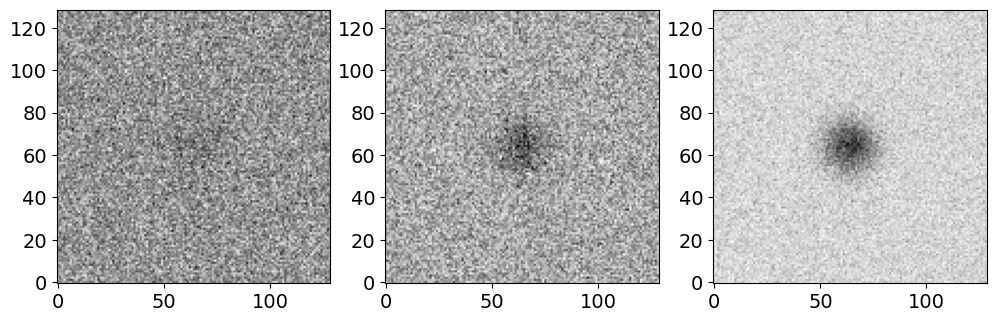

In [223]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))

for logtexp in np.arange(1,4):
    our_imshow(take_exposure(10.**logtexp), q=0., ax=axarr[logtexp-1])

## [1b] Recover the expected SNR scaling with exposure time

Text(0, 0.5, 'SNR')

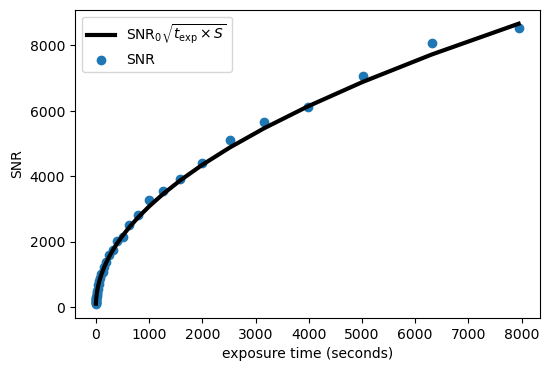

In [77]:
plt.figure(figsize=(6,4))
logtexp_array = np.arange(0., 4, 0.1)
star_count_rate = 100.
sky_sample = np.array([ take_exposure(10.**logtexp, star_count_rate=star_count_rate)[:25,:25].std() for logtexp in logtexp_array ])
star_counts = np.array([ 10.**logtexp * star_count_rate for logtexp in logtexp_array ])

plt.plot(
    10.**logtexp_array,
    np.sqrt(10.**logtexp_array)*(star_counts/sky_sample)[0],
    label=r'SNR$_0\sqrt{t_{\rm exp}\times S}$',
    color='k',
    lw=3
)
plt.scatter(
    10.**logtexp_array,
    star_counts/sky_sample,
    label='SNR',
)

plt.legend()
plt.xlabel('exposure time (seconds)')
plt.ylabel('SNR')

# Problem 2: Build a coadd from homogeneous data

## [2a] Build a mean-weighted coadd

Now that we can "take" single frame exposures, let's start making some coadds -- first, in the case where all exposure are taken under identical conditions.

In [228]:
texp = 10.
star_count_rate = 100.
exposures = np.array([ take_exposure(texp, star_count_rate) for _ in range(100) ])

In [229]:
mw_coadd = np.mean(exposures,axis=0)

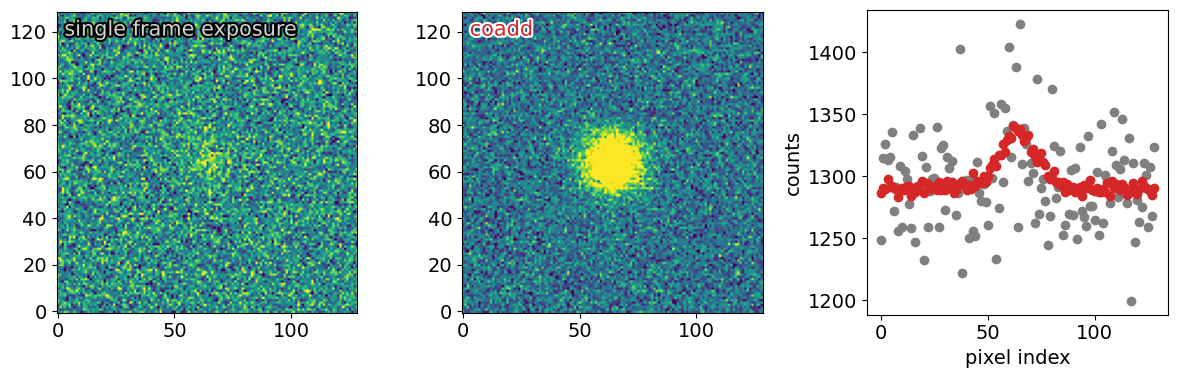

In [230]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(exposures[0], ax=axarr[0], cmap='viridis')
our_imshow(mw_coadd, ax=axarr[1], cmap='viridis')

px = np.arange(exposures[0].shape[1])
axarr[2].scatter(px,np.sum(exposures[0],axis=0), color='grey')
axarr[2].scatter(px,np.sum(mw_coadd,axis=0), color='tab:red')
axarr[2].set_xlabel('pixel index')
axarr[2].set_ylabel('counts')

our_text(0.025,0.975, 'single frame exposure', color='lightgrey', ax=axarr[0], fontsize=15, bordercolor='k', borderwidth=3)
our_text(0.025,0.975, 'coadd', color='tab:red', ax=axarr[1], fontsize=15, bordercolor='w', borderwidth=3)


plt.tight_layout ()

## [2b] Plot coadd depth as a function of the number of coadded images

In [177]:
nstack = np.arange(1, len(exposures)+1)
stack_snr = np.zeros(nstack.shape)
star_counts = texp * star_count_rate

for n in nstack:
    coadd = np.mean(exposures[:n],axis=0)
    sky_sample = coadd[:25,:25].std()
    stack_snr[n-1] = coadd.sum()/sky_sample

Text(0, 0.5, 'SNR')

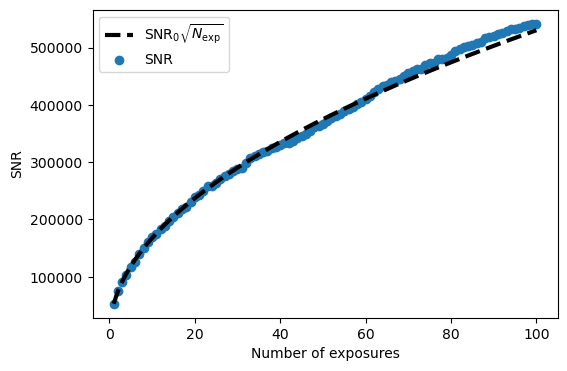

In [178]:
plt.figure(figsize=(6,4))

plt.plot(
    nstack,
    np.sqrt(nstack)*stack_snr[0],
    label=r'SNR$_0\sqrt{N_{\rm exp}}$',
    color='k',
    lw=3,
    ls='--'
)
plt.scatter(
    nstack,
    stack_snr,
    label='SNR',
)

plt.legend()
plt.xlabel('Number of exposures')
plt.ylabel('SNR')

# Problem 3: Build weighted coadds

In the real world, unfortunately, our observing conditions are not homogeneous -- therefore, we want a way to make coadds that take advantage of exposures taken under good conditions and downweight exposures taken under poor conditions. Let's consider two simple cases for making weighted coadds.

## [3a] Variable sky transparency

First let's consider a case where the sky background changes from one exposure to another. Now, we'll add another step (background subtraction) and construct an inverse variance-weighted coadd.

In [218]:
# \\ let's make two populations of exposures: one set taken under good conditions, the other under bad conditions
sky_bg = np.concatenate([np.random.uniform(1., 2., 50), np.random.uniform(50,100.,50)])
star_count_rate = 300.
exposures = [ take_exposure(10., star_count_rate, sky_count_rate) for sky_count_rate in sky_bg ]

In [219]:
bkg_variance = sky_bg * 10.
weights = 1./bkg_variance

bkg_subtracted_exposures = exposures - sky_bg.reshape(-1,1,1)*10.
unweighted_coadd = np.mean(bkg_subtracted_exposures, axis=0)
invvarweighted_coadd = np.sum(bkg_subtracted_exposures*weights.reshape(-1,1,1),axis=0) / weights.sum()

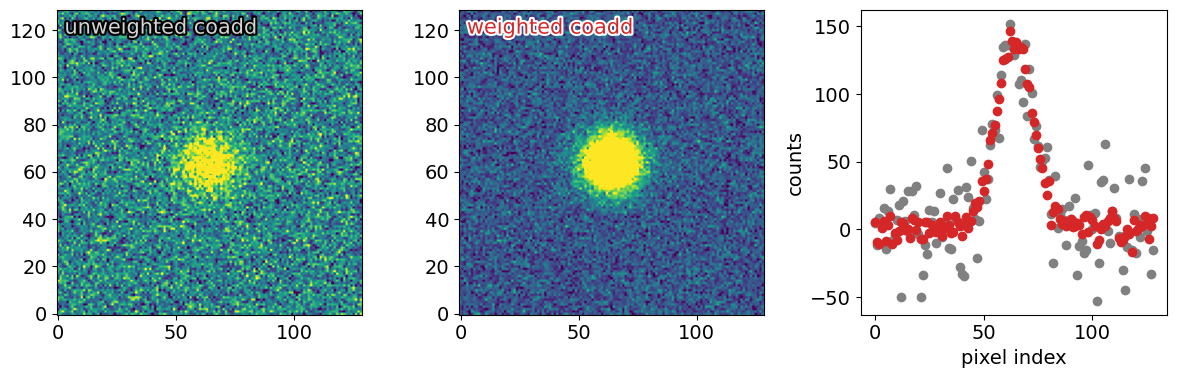

In [227]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(unweighted_coadd, ax=axarr[0], cmap='viridis')
our_imshow(invvarweighted_coadd, ax=axarr[1], cmap='viridis')

px = np.arange(exposures[0].shape[1])
axarr[2].scatter(px,np.sum(unweighted_coadd,axis=0), color='grey')
axarr[2].scatter(px,np.sum(invvarweighted_coadd,axis=0), color='tab:red')
axarr[2].set_xlabel('pixel index')
axarr[2].set_ylabel('counts')

our_text(0.025,0.975, 'unweighted coadd', color='lightgrey', ax=axarr[0], fontsize=15, bordercolor='k', borderwidth=3)
our_text(0.025,0.975, 'weighted coadd', color='tab:red', ax=axarr[1], fontsize=15, bordercolor='w', borderwidth=3)


plt.tight_layout ()

## [3b] Challenge problem: derive and apply the optimal weighting for a point source with variable seeing

# Problem 4: Artifacts and read noise

## [4a] Simulate single frame exposures with read noise and cosmic rays

In [517]:
def add_cosmic_ray ( flux, x0, y0, m, dx, imsize ):
    y,x = np.mgrid[:imsize+1,:imsize+1]
    x_cr = np.arange(x0, x0+dx)
    y_cr = m*(x_cr - x0) + y0
    x_cr = np.where(x_cr>x.max(), np.nan, x_cr)
    y_cr = np.where(y_cr>y.max(), np.nan, y_cr)
    is_inframe = np.where(np.isfinite(x_cr)&np.isfinite(y_cr))
    x_cr = x_cr[is_inframe].astype(int)
    y_cr = y_cr[is_inframe].astype(int)
    img = np.zeros(x.shape)
    img[y_cr,x_cr] = flux
    return img
    
def take_exposure_p4 ( exptime, star_count_rate=100., sky_count_rate=1., fwhm=20., imsize=128, read_noise=10., cr_rate=0.01, cr_flux=100. ):
    y,x = np.mgrid[:imsize+1,:imsize+1]
    xc = imsize//2
    yc = imsize//2
    
    star = gaussian2d(x,y,'normalize',(xc,yc),fwhm/(2.*np.sqrt(2.*np.log(2.))))
    total_count = exptime * star_count_rate
    star *= total_count
    sky = exptime * sky_count_rate

    ncr = (np.random.uniform(0., 1., int(exptime)) > (1.-cr_rate)).sum()
    cosmic_rays = np.zeros(star.shape)
    for _ in range(ncr):
        x0 = np.random.uniform(0, imsize-20)
        y0 = np.random.uniform(0, imsize-20)
        dx = np.random.uniform(2,50)
        m = np.random.uniform(-1,1)
        cosmic_rays += add_cosmic_ray(cr_flux, x0,y0,m,dx,imsize)
    
    signal = star + sky + cosmic_rays
   
    observed_signal = np.random.normal(signal, np.sqrt(signal))
    observed_signal_wreadnoise = observed_signal + np.random.normal(0., read_noise, observed_signal.shape)
    return observed_signal_wreadnoise

<Axes: >

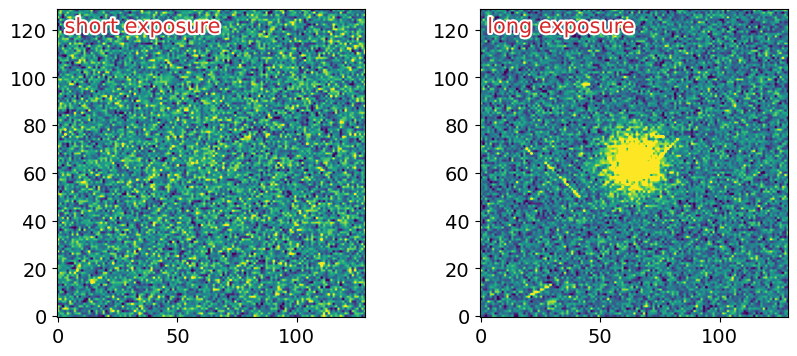

In [390]:
fig, axarr = plt.subplots(1,2,figsize=(10,4))
our_imshow(take_exposure_p4(20., star_count_rate=100., ),  cmap='viridis', ax=axarr[0])
our_imshow(take_exposure_p4(600., star_count_rate=100., ), cmap='viridis',  ax=axarr[1])

our_text(0.025,0.975, 'short exposure', color='tab:red', ax=axarr[0], fontsize=15, bordercolor='w', borderwidth=3)
our_text(0.025,0.975, 'long exposure', color='tab:red', ax=axarr[1], fontsize=15, bordercolor='w', borderwidth=3)

So you might say -- let's just take a ton of short exposures! Then we'll have fewer cosmic rays to deal with, and more exposures to use to filter them out. At very short exposure times, however, you can become read noise dominated. To illustrate this, let's take two sky exposures of different exposure times, then compare their background-subtracted profiles.

In [383]:
long_exp = take_exposure_p4(3600., star_count_rate=0., cr_rate=0.,read_noise=10.)
short_exp = take_exposure_p4(5., star_count_rate=0., cr_rate=0.,read_noise=10.)


In [382]:
long_exp.std()

60.59091209522759

In [384]:
short_exp.std()

10.290738001706424

## [4b] Cosmic ray detection on a single exposure

In this section we'll implement a simplified version of the cosmic ray detection used in HSC-SSP data processing, which itself is the precursor to the LSST science pipelines. We're going to put these cosmic rays in the vicinity of a very bright star to better illustrate the algorithm.

In [514]:
from scipy import ndimage

(<matplotlib.image.AxesImage at 0x31f793a90>, <Axes: >)

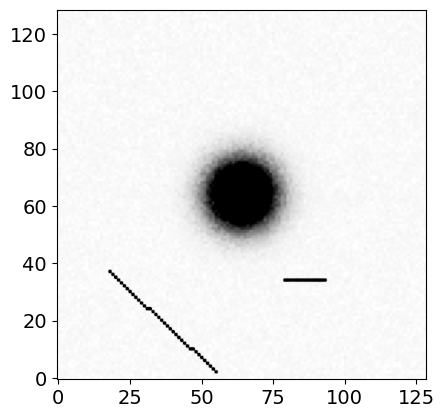

In [590]:
sky_count_rate = 1.
exptime = 50.
fwhm = 20.
exposure_nosky = take_exposure_p4(50., star_count_rate=1e4, sky_count_rate=0., cr_flux=800, cr_rate=0.05, fwhm=fwhm)
sky_bg = np.random.normal(sky_count_rate*exptime, np.sqrt(sky_count_rate*exptime), exposure_nosky.shape)
exposure = exposure_nosky + sky_bg
our_imshow(exposure) # \\ verify visually that you have at least 1 CR in the image

(<matplotlib.image.AxesImage at 0x31f7ee830>, <Axes: >)

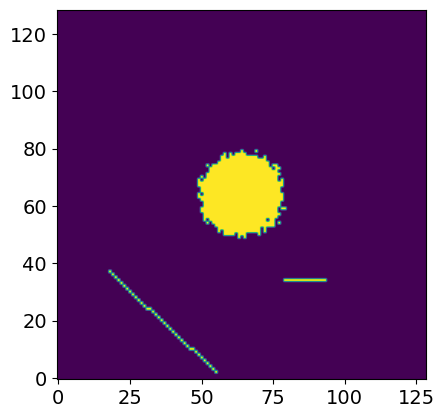

In [591]:
too_bright_factor = 6.
is_too_bright = exposure > (too_bright_factor*sky_bg)
our_imshow(is_too_bright.astype(float), cmap='viridis', q=0)

In [598]:
grad_v0 = exposure - np.pad(exposure[:-4],((4,0),(0,0)))
grad_v1 = exposure - np.pad(exposure[4:],((0,4),(0,0)))
grad_h0 = exposure - np.pad(exposure[:,4:],((0,0),(0,4)))
grad_h1 = exposure - np.pad(exposure[:,:-4],((0,0),(4,0)))
gradients = [grad_v0, grad_v1, grad_h0, grad_h1]

std = fwhm/(2.*np.sqrt(2.*np.log(2.)))
psf_diff = 1. - np.exp ( -4.**2. / (2.*std**2) )

too_sharp_factor = 6.
cr_masks = [ grad > (too_sharp_factor*exposure*psf_diff) for grad in gradients]
morphology_mask = np.sum(cr_masks,axis=0)

cosmic_ray_mask = is_too_bright & (morphology_mask > 1)

(<matplotlib.image.AxesImage at 0x328492200>, <Axes: >)

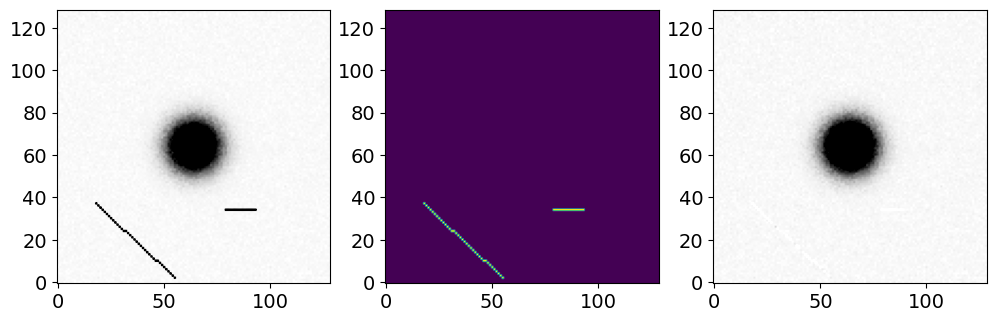

In [603]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(exposure, ax=axarr[0])
axarr[1].imshow(cosmic_ray_mask, origin='lower')
our_imshow(np.where(cosmic_ray_mask, np.random.normal(0., sky_count_rate*exptime, cosmic_ray_mask.shape), exposure), ax=axarr[2])

## [4c] A note on the pitfalls of artifact detection

If we have many exposures to add to a given coadd, one way to reject artifacts is by sigma-clipping the exposures before coadding -- BUT, this invalidates the coadd PSF because of the nonlinearity of the operation.

In [426]:
from astropy.stats.sigma_clipping import SigmaClip

In [476]:
seeing = np.concatenate([np.random.uniform(3.,5., 2),np.random.uniform(20.,30.,20)])
exposures = [ take_exposure_p4(300., star_count_rate=100., cr_flux=150, fwhm=seeing[_]) for _ in range(len(seeing)) ]

In [477]:
mw_coadd = np.mean(exposures, axis=0)

In [480]:
sigclipper = SigmaClip(sigma=3.)

(<matplotlib.contour.QuadContourSet at 0x31b747ac0>, <Axes: >)

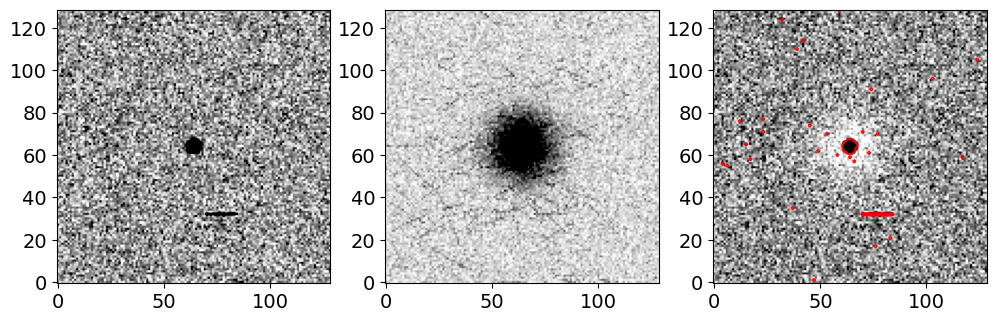

In [481]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(exposures[np.argmin(seeing)], ax=axarr[0])
our_imshow(mw_coadd, ax=axarr[1])
our_imshow(exposures[np.argmin(seeing)] - mw_coadd, ax=axarr[2])
our_contour(sigclipper(exposures, axis=0)[np.argmin(seeing)].mask, ax=axarr[2], colors='r')

In [471]:
sigmaclipped_coadd = sigclipper(exposures, axis=0).mean(axis=0)

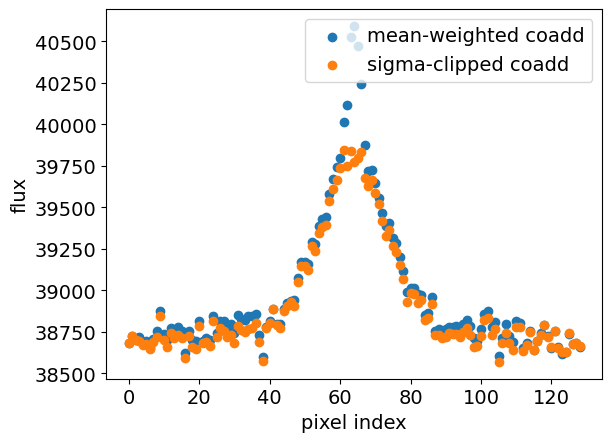

In [473]:
px = np.arange(sigmaclipped_coadd.shape[0])
plt.scatter(px, mw_coadd.sum(axis=0), label='mean-weighted coadd')
plt.scatter(px, sigmaclipped_coadd.sum(axis=0), label='sigma-clipped coadd')
plt.xlabel('pixel index')
plt.ylabel('flux')
plt.legend()